# CPSC8810_HW1-1 Train on Actual Tasks

## Import

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
tf.logging.set_verbosity(tf.logging.ERROR)  # or any {DEBUG, INFO, WARN, ERROR, FATAL}b

In [2]:
tf.__version__

'1.15.0'

## Load Data

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
data.test.cls = np.argmax(data.test.labels, axis=1)

## Data Dimensions

In [5]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

### Helper-function for plotting images

In [6]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Placeholder variables

In [7]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

## Layers Implementation

In [11]:
# layer_conv1
net = tf.layers.conv2d(inputs=x_image, name='layer_conv1', padding='same',
                       filters=16, kernel_size=5, activation=tf.nn.relu)
net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)

# layer_conv2
net = tf.layers.conv2d(inputs=net, name='layer_conv2', padding='same',
                       filters=36, kernel_size=5, activation=tf.nn.relu)
net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)

print(net)

Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 7, 7, 36), dtype=float32)


In [12]:
net = tf.layers.flatten(net)

print(net)

Tensor("flatten/Reshape:0", shape=(?, 1764), dtype=float32)


In [13]:
net = tf.layers.dense(inputs=net, name='layer_fc1',
                      units=128, activation=tf.nn.relu)
logits = tf.layers.dense(inputs=net, name='layer_fc_out',
                      units=num_classes, activation=None)
print(logits)

Tensor("layer_fc_out/BiasAdd:0", shape=(?, 10), dtype=float32)


In [14]:
y_pred = tf.nn.softmax(logits=logits)
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [15]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=logits)

In [16]:
loss = tf.reduce_mean(cross_entropy)

### Optimization Method

In [17]:
opt = tf.train.AdamOptimizer(learning_rate=1e-4)
optimizer = opt.minimize(loss)

### Classification Accuracy

In [18]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Getting the Weights

In [19]:
#trainable_var_list = []
#for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
#    trainable_var_list.append(var)
#    print(var)

trainable_var_list = tf.trainable_variables()

In [20]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'kernel' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.

    with tf.variable_scope(layer_name, reuse=True):
        variable = tf.get_variable('kernel')

    return variable

In [21]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')
print(weights_conv1)
print(weights_conv2)

weights_fc1 = get_weights_variable(layer_name='layer_fc1')
weights_fc_out = get_weights_variable(layer_name='layer_fc_out')
print(weights_fc1)
print(weights_fc_out)

<tf.Variable 'layer_conv1/kernel:0' shape=(5, 5, 1, 16) dtype=float32_ref>
<tf.Variable 'layer_conv2/kernel:0' shape=(5, 5, 16, 36) dtype=float32_ref>
<tf.Variable 'layer_fc1/kernel:0' shape=(1764, 128) dtype=float32_ref>
<tf.Variable 'layer_fc_out/kernel:0' shape=(128, 10) dtype=float32_ref>


## TensorFlow Run

### Create TensorFlow session

In [22]:
session = tf.Session()

### Initialize variables

In [23]:
session.run(tf.global_variables_initializer())

### Get gradients during training

In [24]:
#grad = opt.compute_gradients(loss, weights_fc_out)[0]
grads = tf.gradients(loss, weights_fc_out)[0]
print(grads)

Tensor("gradients_1/layer_fc_out/MatMul_grad/MatMul_1:0", shape=(128, 10), dtype=float32)


### Hessian Computation

In [25]:
# arg1: our defined function, arg2: list of tf variables associated with the function
hessian = tf.reduce_sum(tf.hessians(loss, weights_fc_out)[0], axis = 2)
print(hessian)

Tensor("Sum:0", shape=(128, 10, 10), dtype=float32)


In [26]:
train_batch_size = 64

In [27]:
# Counter for total number of iterations performed so far.
total_iterations = 0


def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations
    loss_list = []
    acc_list = []
    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        
        # Save loss of each step
        los, acc = session.run([loss, accuracy], feed_dict=feed_dict_train)
        loss_list.append(los)
        acc_list.append(acc)
        
        if i % 10 == 0:
            # Calculate the accuracy on the training-set.
            los, acc = session.run([loss, accuracy], feed_dict=feed_dict_train)
            
            grads_vals, hess_vals = session.run([grads, hessian], feed_dict=feed_dict_train)
            
            #print(grads_vals.shape)
            #print(hess_vals.shape)

            # Message for printing.
            msg = "Iteration: {0:>6}, Training Loss: {1:>1.6}, Training Accuracy: {2:>6.1%}"

            # Print it.
            print(msg.format(i + 1, los, acc))
            

    # Update the total number of iterations performed.
    total_iterations += num_iterations
    
    # Plot loss
    plt.plot(loss_list)
    plt.ylabel('Train Loss')
    plt.show()
    
    # Plot acc
    plt.plot(acc_list)
    plt.ylabel('Train Acc')
    plt.show()
    

In [28]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy():

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls
    
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

Iteration:      1, Training Loss: 2.27114, Training Accuracy:  20.3%
Iteration:     11, Training Loss: 2.21213, Training Accuracy:  28.1%
Iteration:     21, Training Loss: 2.11442, Training Accuracy:  50.0%
Iteration:     31, Training Loss: 2.06747, Training Accuracy:  65.6%
Iteration:     41, Training Loss: 1.95876, Training Accuracy:  56.2%
Iteration:     51, Training Loss: 1.783, Training Accuracy:  70.3%
Iteration:     61, Training Loss: 1.69977, Training Accuracy:  75.0%
Iteration:     71, Training Loss: 1.3801, Training Accuracy:  78.1%
Iteration:     81, Training Loss: 1.36977, Training Accuracy:  70.3%
Iteration:     91, Training Loss: 1.2068, Training Accuracy:  76.6%
Iteration:    101, Training Loss: 0.950422, Training Accuracy:  87.5%
Iteration:    111, Training Loss: 1.01781, Training Accuracy:  70.3%
Iteration:    121, Training Loss: 0.673728, Training Accuracy:  79.7%
Iteration:    131, Training Loss: 0.775756, Training Accuracy:  76.6%
Iteration:    141, Training Loss: 0

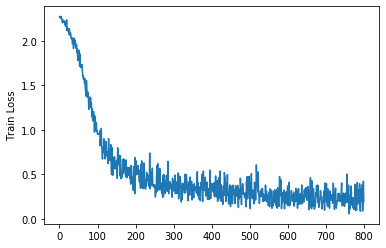

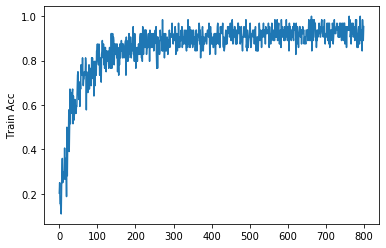

CPU times: user 3min, sys: 8.77 s, total: 3min 8s
Wall time: 22.1 s


In [29]:
%%time
optimize(num_iterations=800) # We already performed 1 iteration above.
#plt(loss_list)

In [30]:
print_test_accuracy()

Accuracy on Test-Set: 93.7% (9366 / 10000)


In [31]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [32]:
from sklearn.decomposition import PCA
def plot_fc_weights(weights_list):
    # Assume weights in weights_list are TensorFlow ops for 2-dim variables
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w_list = session.run(weights_list)
    
    pca = PCA(n_components=2)
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    
    for w in w_list:
            
        print(w.shape)

        principalComponents = pca.fit_transform(w)

        ax.scatter(principalComponents[:,0], principalComponents[:,1], label=w.shape, alpha=0.5)

    ax.legend()
    plt.show()

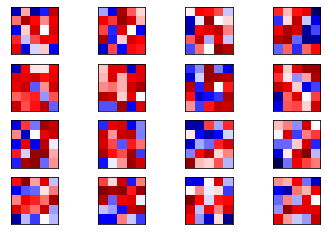

In [33]:
plot_conv_weights(weights=weights_conv1)

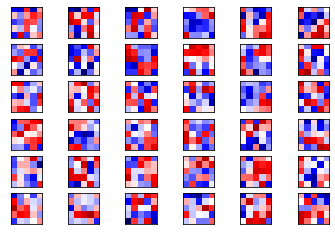

In [34]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

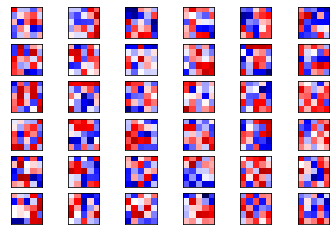

In [35]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

(1764, 128)
(128, 10)


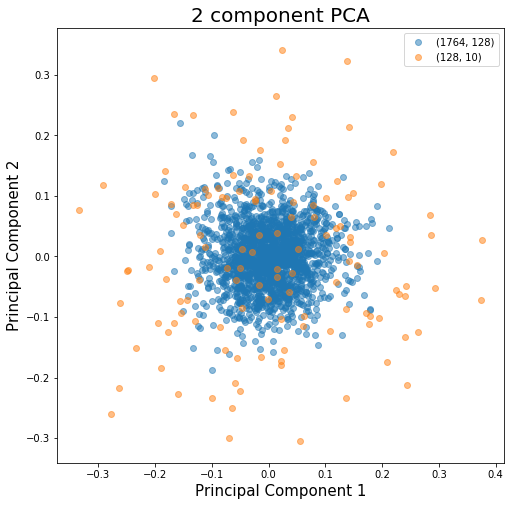

In [36]:
plot_fc_weights(weights_list=[weights_fc1, weights_fc_out])